ПОСТАНОВКА ЗАДАЧИ

Нам предоставлены результаты A/A/B-тестирования от одного известного маркетплейса. 

sample_a,  sample_c — АА-группы,  
sample_b — отдельная группа. 

В каждом датасете есть три типа действий пользователей: 0 — клик, 1 — просмотр и 2 — покупка (пользователь просматривает выдачу товаров, кликает на понравившийся товар и совершает покупку).

Маркетплейс ориентируется на следующие метрики:

ctr (отношение кликов к просмотрам товаров);  
purchase rate (отношение покупок к просмотрам товаров);  
gmv (оборот, сумма произведений количества покупок на стоимость покупки), где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).  

Требуется провести анализ A/A/B тестирования.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Импорт данных
DATADIR = 'data/10/'
df_item = pd.read_csv(DATADIR + 'item_prices.csv')
df_a = pd.read_csv(DATADIR + 'sample_a.csv')
df_b = pd.read_csv(DATADIR + 'sample_b.csv')
df_c = pd.read_csv(DATADIR + 'sample_c.csv')

In [3]:
df_item.head()

,item_id,item_price
0,338,1501
1,74,647
2,7696,825
3,866,875
4,5876,804


In [4]:
df_a.head()

,user_id,item_id,action_id
0,84636,360,1
1,21217,9635,1
2,13445,8590,1
3,38450,5585,1
4,14160,2383,0


In [5]:
def view_data(data):
    """ Анализ датасета """
    df = data.copy()
    print('Дубликаты')
    print(df.duplicated().sum())
    
    print('Shape')
    print(df.shape)


In [6]:
for df in [df_a, df_b, df_c]:
    view_data(df)

Дубликаты
0
Shape
(1188912, 3)
Дубликаты
0
Shape
(1198438, 3)
Дубликаты
0
Shape
(1205510, 3)


Наборы данных практически совпадают по количеству наблюдений.  
Дубликаты отсутствуют

In [7]:
df_a.action_id.unique()

array([1, 0, 2], dtype=int64)

Типы событий - согласно описанию  
0 — клик, 1 — просмотр и 2 — покупка

In [8]:
# Категориальные признаки приведём к читаемому виду
ds = [df_a, df_b, df_c]

actions_dict = {0: 'click', 1: 'view', 2: 'buy'}

for sample in ds:
    sample['action_cat'] = sample.action_id.map(actions_dict)

<AxesSubplot:xlabel='action_cat', ylabel='count'>

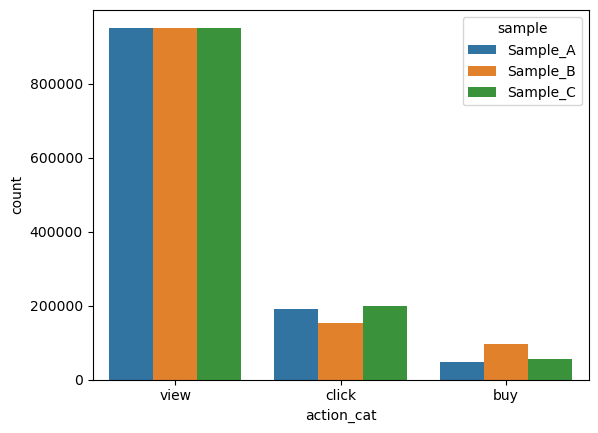

In [9]:
# Отобразим данные на графике
df_a['sample'] = 'Sample_A'
df_b['sample'] = 'Sample_B'
df_c['sample'] = 'Sample_C'

df_abc = pd.concat([df_a, df_b, df_c])
sns.countplot(data=df_abc, x='action_cat', hue='sample')

Согласно полученному графику, можно сделать следующий вывод:  
Поведение пользователей A/C в целом схожи. У "C", результативность чуть лучше.    
Поведение пользователей A/B уже заметно отличаются. При одинаковом количестве просмотров, у "B" меньше переходов (click), но при этом больше покупок(buy).

Преобразуем наши датасеты трансформируя категориальные признаки

In [10]:
def transform(data):
    """ Транфсормирует категориальные признаки """
    data['action_id'] = 1
    newdf = pd.pivot_table(data, 
                           index=['user_id', 'item_id'],
                           columns=['action_cat'],
                           values='action_id')
    newdf = newdf.fillna(0)
    newdf = newdf.reset_index()
    
    return newdf

In [11]:
df_a = transform(df_a)
df_b = transform(df_b)
df_c = transform(df_c)

In [12]:
df_a

action_cat,user_id,item_id,buy,click,view
0,241,21,0.0,0.0,1.0
1,241,36,0.0,0.0,1.0
2,241,39,0.0,0.0,1.0
3,241,50,0.0,0.0,1.0
4,241,64,0.0,0.0,1.0
...,...,...,...,...,...
951125,99880,9936,0.0,0.0,1.0
951126,99880,9944,0.0,0.0,1.0
951127,99880,9958,0.0,0.0,1.0
951128,99880,9989,0.0,0.0,1.0


Проверим есть ли наблюдения, в которых есть покупка или клик без просмотра

In [13]:
# Datasets
ds = [df_a, df_b, df_c]

def get_counts(data):
    print(data[['buy','click','view']].value_counts())

for sample in ds:
    get_counts(sample)

buy  click  view
0.0  0.0    1.0     722858
     1.0    1.0     180716
1.0  0.0    1.0      38046
     1.0    1.0       9510
dtype: int64
buy  click  view
0.0  0.0    1.0     719023
     1.0    1.0     137004
1.0  0.0    1.0      79935
     1.0    1.0      15179
dtype: int64
buy  click  view
0.0  0.0    1.0     704875
     1.0    1.0     187393
1.0  0.0    1.0      45010
     1.0    1.0      11943
dtype: int64


Мы можем наблюдать, что действие view применимо к 100% товаров.  
Но при этом, есть покупки без кликов: buy=1, click=0.

In [14]:
# Если это действие недопустимо, заложим в наш сценарий возможность очистки.
# def remove_zeroclick(data):
#    """ Удаляет наблюдения с покупками без кликов """
#    return data.drop(data[(data.click==0) & (data.buy==1)].index)
#
# df_a = remove_zeroclick(df_a)
# df_b = remove_zeroclick(df_b)
# df_c = remove_zeroclick(df_c)

Маркетплейс ориентируется на следующие метрики:

- ctr (отношение кликов к просмотрам товаров);
- purchase rate (отношение покупок к просмотрам товаров);
- gmv (оборот, сумма произведений количества покупок на стоимость покупки), где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).

In [15]:
df_sum = pd.DataFrame({'sample':['sample_a','sample_b','sample_c']})

In [16]:
# Вычислим ctr
def calc_ctr(data):
    """ Вычисляет ctr """
    return round(data.click.sum()/data.view.sum(), 4)*100

ctr = []
for sample in ds:
    ctr.append(calc_ctr(sample))
df_sum['ctr'] = ctr

In [17]:
# Вычислим purchase rate
def calc_purchase_rate(data):
    """ Вычисляет purchase rate """
    return round(data.buy.sum()/data.view.sum(), 4)*100

purchase_rate = []
for sample in ds:
    purchase_rate.append(calc_purchase_rate(sample))
df_sum['purchase_rate'] = purchase_rate

In [18]:
# Вычислим GMV
def get_price(data):
    """ Объединение с прайсом """
    return data.merge(df_item, on='item_id', how='left')

df_a = get_price(df_a)
df_b = get_price(df_b)
df_c = get_price(df_c)

ds = [df_a, df_b, df_c]
gmv = []
for sample in ds:
    gmv.append(round(sample[sample.buy == 1].item_price.sum(), 4))
df_sum['gmv'] = gmv

In [19]:
df_sum

,sample,ctr,purchase_rate,gmv
0,sample_a,20.0,5.0,53060177
1,sample_b,16.0,10.0,106047378
2,sample_c,21.0,6.0,63614910


C:\Users\Lyo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


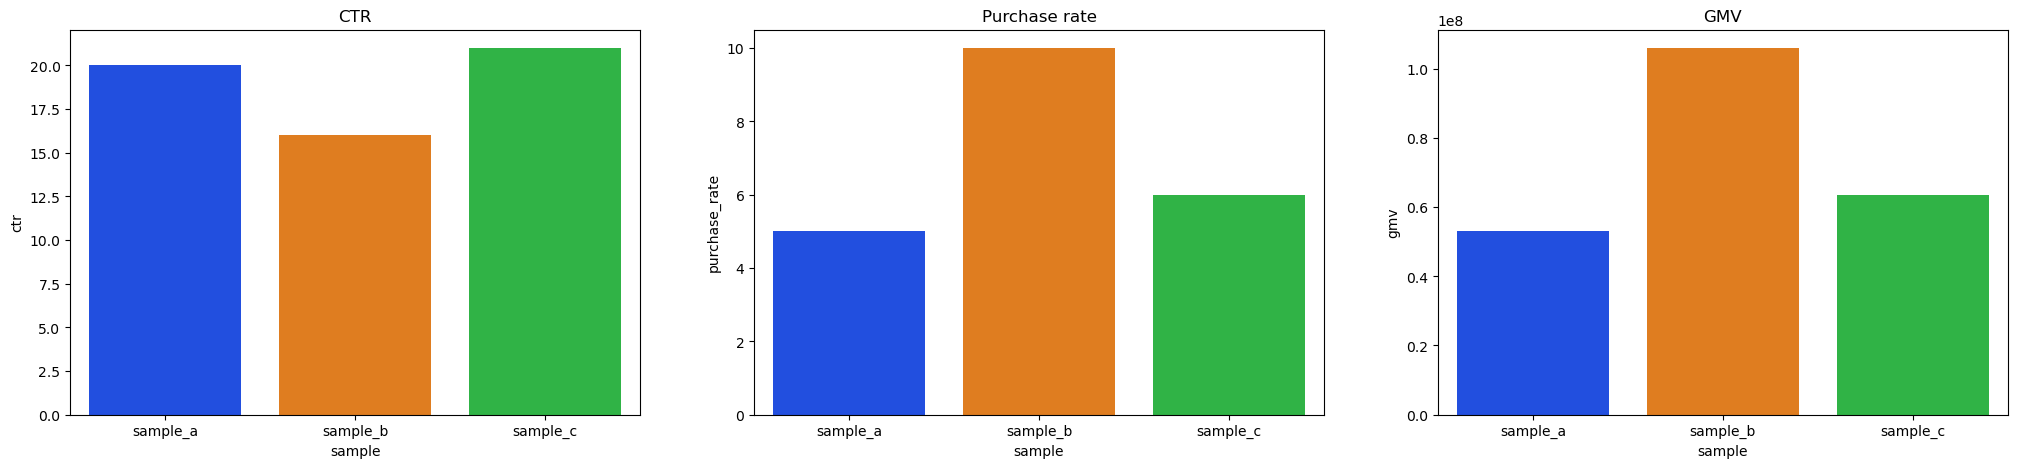

In [20]:
# Визуализируем полученные метрики
fig, axs = plt.subplots(1,3, figsize=(25, 5))

sns.barplot(ax=axs[0],
            x="sample",
            y="ctr",
            data=df_sum,
            palette="bright").set(title="CTR")

sns.barplot(ax=axs[1],
            x="sample",
            y="purchase_rate",
            data=df_sum,
            palette="bright").set(title="Purchase rate")

sns.barplot(ax=axs[2],
            x="sample",
            y="gmv",
            data=df_sum,
            palette="bright").set(title="GMV")

fig.show()

Согласно полученным данным, Sample_A и Sample_C показывают одинаковую динамику, хотя показатели Sample_C несколько выше.  
Sample_B заметно отличается поведением. Кликабельность(CTR) Sample_B ниже, но при этом Purshase rate и GMV - заметно выше.

Проведем тест Шапиро-Уилка на нормальность

In [21]:
# Проанализируем датасеты в разрезе пользователя
def customer_metrics(data):
    """ Группировка по пользователю """
    # Стоимость покупок для подсчёта gmv
    data['purchase'] = data['buy'] * data['item_price']
    
    data = data[['user_id', 'buy', 'click', 'view', 'purchase']].groupby('user_id').agg(sum)
    data['ctr'] = 100 * data.click / data.view
    data['purchase_rate'] = 100 * data.buy / data.click
    data['gmv'] = data['purchase']
    return data

df_customer_a = customer_metrics(df_a)
df_customer_b = customer_metrics(df_b)
df_customer_c = customer_metrics(df_c)

df_customer_a['sample'] = 'sample_a'
df_customer_b['sample'] = 'sample_b'
df_customer_c['sample'] = 'sample_c'

In [22]:
# CTR
ds = [df_customer_a, df_customer_b, df_customer_c]
ctr_pvalue = []
for sample in ds:
    ctr_pvalue.append(shapiro(sample.ctr).pvalue)
df_sum['ctr_pvalue'] = ctr_pvalue

In [23]:
# Purchase rate
pr_pvalue = []
for sample in ds:
    pr_pvalue.append(shapiro(sample.purchase_rate).pvalue)
df_sum['pr_pvalue'] = pr_pvalue

In [24]:
# GMV
gmv_pvalue = []
for sample in ds:
    gmv_pvalue.append(shapiro(sample.gmv).pvalue)
df_sum['gmv_pvalue'] = gmv_pvalue
df_sum

,sample,ctr,purchase_rate,gmv,ctr_pvalue,pr_pvalue,gmv_pvalue
0,sample_a,20.0,5.0,53060177,0.004503,0.001463,0.125194
1,sample_b,16.0,10.0,106047378,0.710634,0.003972,0.845828
2,sample_c,21.0,6.0,63614910,0.129967,0.004231,0.019793


In [25]:
alpha = 0.01

In [26]:
df_sum['ctr_normal'] = (df_sum.ctr_pvalue > alpha)
df_sum['pr_normal'] = (df_sum.pr_pvalue > alpha)
df_sum['gmv_normal'] = (df_sum.gmv_pvalue > alpha)

In [27]:
df_sum

,sample,ctr,purchase_rate,gmv,ctr_pvalue,pr_pvalue,gmv_pvalue,ctr_normal,pr_normal,gmv_normal
0,sample_a,20.0,5.0,53060177,0.004503,0.001463,0.125194,False,False,True
1,sample_b,16.0,10.0,106047378,0.710634,0.003972,0.845828,True,False,True
2,sample_c,21.0,6.0,63614910,0.129967,0.004231,0.019793,True,False,True


При уровне значимости равным 0.01, во всех датасетах "Purchase rate", а так же ctr у Sample_A не имеют нормального распределения.  
Похоже, что в наблюдениях поведение пользователей сильно отличается.

[Text(0.5, 1.0, 'Gmv')]

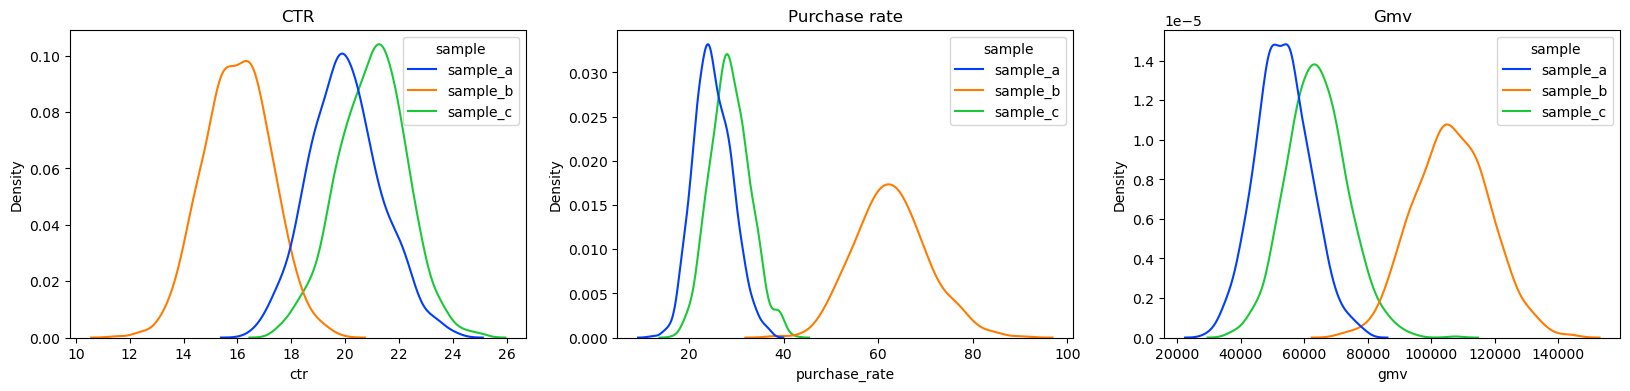

In [28]:
# Визуализация распределения (kernel density estimation)
df_customer_sum = pd.concat([df_customer_a, df_customer_b, df_customer_c], ignore_index=True)

f, axs = plt.subplots(1,3, figsize=(20, 4))

sns.kdeplot(ax=axs[0],
            x="ctr",
            hue="sample",
            data=df_customer_sum,
            palette="bright").set(title="CTR")

sns.kdeplot(ax=axs[1],
            x="purchase_rate",
            hue="sample",
            data=df_customer_sum,
            palette="bright").set(title="Purchase rate")

sns.kdeplot(ax=axs[2],
            x="gmv",
            hue="sample",
            data=df_customer_sum,
            palette="bright").set(title="Gmv")

Проведём оценку равности долей (Z-test)

In [29]:
alpha = 0.05

In [30]:
def get_ztest_metrics(df1, df2, column):
    """ Тест на равенство долей """
    count = [df1[column].sum(), df2[column].sum()]
    nobs = [len(df1[column]), len(df2[column])]
    stat, pval = proportions_ztest(count, nobs)
    print(f'p-value: {pval}')
    print(f'Тест на равенство долей: {pval > alpha}')
    return pval

In [31]:
# Итоговый DataFrame
df_abtest = pd.DataFrame({'Datasets': [], 'Column': [], 'Pvalue': [], 'Similar': []})

Тест равенства долей A/C

In [32]:
for column in ['click', 'buy']:
    print(column)
    pvalue = get_ztest_metrics(df_a, df_c, column)
    df_abtest.loc[len(df_abtest)] = ['df_a/df_c', column, pvalue, pvalue > alpha]

click
p-value: 7.030828728094025e-67
Тест на равенство долей: False
buy
p-value: 1.959683539900351e-214
Тест на равенство долей: False


Тест равенства долей A/B

In [33]:
for column in ['click', 'buy']:
    print(column)
    pvalue = get_ztest_metrics(df_a, df_b, column)
    df_abtest.loc[len(df_abtest)] = ['df_a/df_b', column, pvalue, pvalue > alpha]

click
p-value: 0.0
Тест на равенство долей: False
buy
p-value: 0.0
Тест на равенство долей: False


In [34]:
# Результат
df_abtest

,Datasets,Column,Pvalue,Similar
0,df_a/df_c,click,7.030829e-67,0.0
1,df_a/df_c,buy,1.959684e-214,0.0
2,df_a/df_b,click,0.000000e+00,0.0
3,df_a/df_b,buy,0.000000e+00,0.0


Поскольку pvalue меньше 0.05, нулевая гипотеза отвергается. Равенство долей не подтверждается.

Вывод: Тесты на нормальность и равенство долей говорят нам о разнородности датасетов.  
Возможно, не просто добиться идеальной выборки.  
При этом, поведение А и С групп схожее, в то время как поведение пользователей группы B заметно отличается.  
Показатели, "Purchase rate" и "GMV" у группы B, заметно выше.